In [1]:
import os 
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras import backend

2025-03-26 03:21:38.482591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = "/Users/user/Downloads/Fruit Classification Project/MY_data/train"

In [3]:
import os
import tensorflow as tf

num_skipped = 0

# Replace these with your actual fruit class folder names
fruit_classes = ("apple", "Banana", "orange", "cherry", "avocado","pinenapple","kiwi","mango","strawberries","watermelon")  

# Adjust to your dataset path
base_path = "/Users/user/Downloads/Fruit Classification Project/MY_data/train"

for folder_name in fruit_classes:
    folder_path = os.path.join(base_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = b"JFIF" in fobj.peek(10)
        except Exception as e:
            print(f"Error reading file {fpath}: {e}")
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            try:
                os.remove(fpath)
            except Exception as e:
                print(f"Failed to delete {fpath}: {e}")

print(f"Deleted {num_skipped} unsupported/corrupted images.")


Deleted 0 unsupported/corrupted images.


In [4]:
image_size = (320, 320)
batch_size = 32

In [5]:
import tensorflow as tf

# Define your dataset path
dataset_path = "/Users/user/Downloads/Fruit Classification Project/MY_data/train"

# Set your image size and batch size
image_size = (320, 320)      # or whatever size your model expects
batch_size = 32              # you can tweak this depending on your RAM

# Load the training set (80%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

# Load the validation set (20%)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 2285 files belonging to 10 classes.
Using 1828 files for training.
Found 2285 files belonging to 10 classes.
Using 457 files for validation.


2025-03-26 03:23:15.056160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


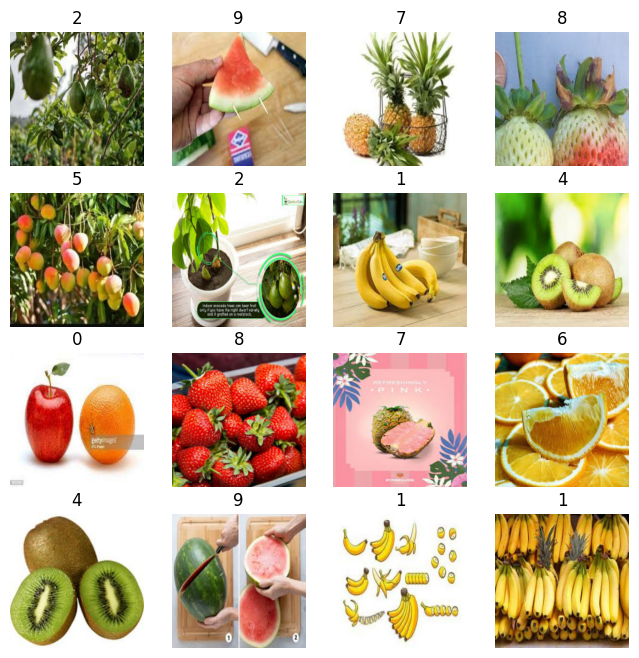

In [6]:
#Visualization of data - First 16 images
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
img_width = 320
img_height = 320

if backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    modelx = layers.Rescaling(1.0 / 255)(inputs)
    modelx = layers.Conv2D(32, 3, strides=2, padding="same", activation = 'relu')(modelx)
    modelx = layers.Conv2D(64, 3, padding="same", activation='relu')(modelx)
    previous_block_activation = modelx
    
    for size in [128, 256, 512, 384]:
        modelx = layers.Activation("relu")(modelx)
        modelx = layers.SeparableConv2D(size, 3, padding="same")(modelx)
        modelx = layers.BatchNormalization()(modelx)

        modelx = layers.Activation("relu")(modelx)
        modelx = layers.SeparableConv2D(size, 3, padding="same")(modelx)
        modelx = layers.BatchNormalization()(modelx)

        modelx = layers.MaxPooling2D(3, strides=2, padding="same")(modelx)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation) # Project residual
        modelx = layers.add([modelx, residual])  
        previous_block_activation = modelx  
    
    modelx = layers.SeparableConv2D(1024, 3, padding="same", activation = 'relu')(modelx)
    modelx = layers.GlobalAveragePooling2D()(modelx)
    
    outputs = layers.Dense(num_classes, activation="softmax")(modelx)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape, num_classes=10)

In [12]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 320, 320,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │        896 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 160, 160,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 160, 160,  │      8,896 │ activation[0][0]  │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 160, 160,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 160, 160,  │     17,664 │ activation_1[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │      8,320 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 80, 80,    │     34,176 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 80, 80,    │          0 │ batch_normalizat

 Total params: 1,690,378 (6.45 MB)

 Trainable params: 1,685,258 (6.43 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [14]:
model.fit(train_ds, epochs=15, callbacks=callbacks, validation_data=val_ds)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2589 - loss: 1.9617   

58/58 ━━━━━━━━━━━━━━━━━━━━ 969s 17s/step - accuracy: 0.2604 - loss: 1.9585 - val_accuracy: 0.0897 - val_loss: 2.3058
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4466 - loss: 1.5672   

58/58 ━━━━━━━━━━━━━━━━━━━━ 959s 16s/step - accuracy: 0.4471 - loss: 1.5655 - val_accuracy: 0.1050 - val_loss: 2.3255
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4723 - loss: 1.4819   

58/58 ━━━━━━━━━━━━━━━━━━━━ 968s 17s/step - accuracy: 0.4729 - loss: 1.4806 - val_accuracy: 0.1291 - val_loss: 2.3753
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5386 - loss: 1.3436   

58/58 ━━━━━━━━━━━━━━━━━━━━ 985s 17s/step - accuracy: 0.5392 - loss: 1.3418 - val_accuracy: 0.1204 - val_loss: 2.4928
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5757 - loss: 1.2464   

58/58 ━━━━━━━━━━━━━━━━━━━━ 927s 16s/step - accuracy: 0.5759 - loss: 1.2455 - val_accuracy: 0.1291 - val_loss: 2.7345
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.6364 - loss: 1.0940   

58/58 ━━━━━━━━━━━━━━━━━━━━ 1504s 26s/step - accuracy: 0.6361 - loss: 1.0943 - val_accuracy: 0.1138 - val_loss: 2.6599
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6294 - loss: 1.0673   

58/58 ━━━━━━━━━━━━━━━━━━━━ 989s 17s/step - accuracy: 0.6297 - loss: 1.0664 - val_accuracy: 0.1138 - val_loss: 2.6507
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6317 - loss: 1.0565   

58/58 ━━━━━━━━━━━━━━━━━━━━ 935s 16s/step - accuracy: 0.6320 - loss: 1.0554 - val_accuracy: 0.1138 - val_loss: 2.5858
Epoch 9/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6660 - loss: 0.9725   

58/58 ━━━━━━━━━━━━━━━━━━━━ 1132s 20s/step - accuracy: 0.6660 - loss: 0.9722 - val_accuracy: 0.1138 - val_loss: 3.1916
Epoch 10/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6856 - loss: 0.9455   

58/58 ━━━━━━━━━━━━━━━━━━━━ 1226s 21s/step - accuracy: 0.6856 - loss: 0.9450 - val_accuracy: 0.1160 - val_loss: 3.1737
Epoch 11/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7082 - loss: 0.8360   

58/58 ━━━━━━━━━━━━━━━━━━━━ 1019s 18s/step - accuracy: 0.7084 - loss: 0.8353 - val_accuracy: 0.1751 - val_loss: 2.3838
Epoch 12/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6833 - loss: 0.9122   

58/58 ━━━━━━━━━━━━━━━━━━━━ 1214s 21s/step - accuracy: 0.6837 - loss: 0.9112 - val_accuracy: 0.1510 - val_loss: 2.7474
Epoch 13/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7095 - loss: 0.7896   

58/58 ━━━━━━━━━━━━━━━━━━━━ 800s 14s/step - accuracy: 0.7099 - loss: 0.7888 - val_accuracy: 0.2451 - val_loss: 2.3620
Epoch 14/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7061 - loss: 0.8595   

58/58 ━━━━━━━━━━━━━━━━━━━━ 843s 15s/step - accuracy: 0.7062 - loss: 0.8591 - val_accuracy: 0.5449 - val_loss: 1.3465
Epoch 15/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7302 - loss: 0.7683   

58/58 ━━━━━━━━━━━━━━━━━━━━ 844s 15s/step - accuracy: 0.7307 - loss: 0.7667 - val_accuracy: 0.5514 - val_loss: 1.4208


In [14]:
model.save("fruit_model.keras")
model.save("/Users/user/SC4031Sample/fruit_model.keras")

In [15]:
import numpy as np

image = keras.preprocessing.image.load_img("/Users/user/Downloads/Fruit Classification Project/MY_data/predict/f2.jpeg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
pred = np.squeeze(predictions)

print(pred)
classes = {0: "avocado", 1:"apple", 2:"Banana", 3:"orange", 4:"cherry", 5: "pinenapple", 6:"kiwi",7:"mango",8:"strawberries",9:"watermelon"}
highest_pred_loc = np.argmax(pred)
accuracy = pred[highest_pred_loc]
fruit = classes[highest_pred_loc]
print("This image is %.2f percent %s." % (100 * accuracy, fruit))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[4.5512375e-04 9.6216972e-05 2.1836348e-04 6.3897865e-03 9.0481517e-06
 1.5561052e-05 1.0616368e-03 7.5860764e-03 9.8151749e-01 2.6506265e-03]
This image is 98.15 percent strawberries.


In [15]:
!{sys.executable} -m pip install keras_applications

In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models

# Load your trained model
model_with_aug = load_model("imagereg_org.h5")

model = tf.keras.models.load_model('model_full.h5', compile=False)

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_full.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [26]:
import tensorflow as tf
print(tf.__version__)  # Should print the installed TensorFlow version


2.16.2


In [5]:
import sys
!{sys.executable} -m pip install keras_vggface
!{sys.executable} -m pip install tensorflow==1.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 5.3 MB/s eta 0:00:0000:0100:01
ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.2 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2)
ERROR: No matching distribution found for tensorflow==1.13.2
